<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_VAE/blob/master/2_vae_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder**

Reference: Diederik P. Kingma and Max Welling, “Auto-Encoding Variational Bayes,” arXiv preprint arXiv:1312.6114, 2013.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# Image directory
dir_image = '/content/gdrive/My Drive/Colab Notebooks/pic'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###**Set training parameters**

In [ ]:
# Parameters
learning_rate = 1e-3
training_epochs = 50
batch_size = 32
display_step = 5

###**Load MNIST data**
Set train & test data

In [ ]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(60000)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .shuffle(10000)
    .batch(batch_size)
)

In [ ]:
dim_x = np.shape(x_train)[1:]

###**Set model**


In [ ]:
class VAE(keras.Model):
  """a basic vae class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(VAE, self).__init__()
    self.__dict__.update(kwargs)

    self.dim_x_prod = reduce( (lambda x, y: x * y), self.dim_x)

    # Set network
    self.enc_nn = keras.Sequential(self.enc_desc)
    self.dec_nn = keras.Sequential(self.dec_desc)

  def encode(self, x):
    mu, sigma_ = tf.split(self.enc_nn(x), num_or_size_splits=2, axis=1)
    sigma = keras.backend.softplus(sigma_) + 1e-6
    return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

  def decode(self, z):
    return self.dec_nn(z)

  def reconstruct(self, x):
      mu, _ = tf.split(self.enc_nn(x), num_or_size_splits=2, axis=1)
      return self.decode(mu)

  @tf.function
  def compute_loss(self, x):
    q_z = self.encode(x)
    z = q_z.sample()
    x_recon = self.decode(z)

    # Compute KL-divergence
    p_z = ds.MultivariateNormalDiag(
        loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
        )
    kl_div = ds.kl_divergence(q_z, p_z)
    loss_latent = tf.reduce_mean(tf.maximum(kl_div, 0))

    # Compute reconstruction loss
    _diffsq_x = tf.math.square(x - x_recon)
    diffsq_x = tf.reshape(_diffsq_x, [-1, self.dim_x_prod])
    _loss_recon = tf.reduce_sum(diffsq_x, axis=-1, keepdims=True)
    loss_recon = tf.reduce_mean(_loss_recon)

    return loss_latent, loss_recon

  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
        loss_latent, loss_recon = self.compute_loss(x)
        loss_sum = loss_latent + loss_recon
    cg = tape.gradient(loss_sum, self.enc_nn.trainable_variables + 
                       self.dec_nn.trainable_variables)
    return cg, loss_latent, loss_recon
  
  @tf.function
  def train(self, x):
    """ Trains model. """
    cg, loss_latent, loss_recon = self.compute_gradients(x)
    self.optimizer.apply_gradients(zip(cg, self.enc_nn.trainable_variables + 
                                       self.dec_nn.trainable_variables))
    return loss_latent, loss_recon

In [ ]:
dim_z = 2

enc_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
            keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Flatten(),
            keras.layers.Dense(units=dim_z*2)]

dec_desc = [keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
            keras.layers.Reshape(target_shape=(7, 7, 64)),
            keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="same", activation="sigmoid")
            ]

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
vae = VAE(dim_x=dim_x, enc_desc=enc_desc, dec_desc=dec_desc, optimizer=optimizer)

### Train model

In [ ]:
# Test-data for plot
test_data_plot = next(iter(test_data))

import matplotlib.pyplot as plt

def plot_train(model, x, nex=6, zm=2, epoch=0):
  x_recon = model.reconstruct(x)
  x_sample = model.decode(tf.random.normal(shape=(batch_size, dim_z)))
  
  fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
  
  for axi, (dat, lab) in enumerate(zip([x, x_recon, x_sample],
                                       ["data", "data_recon", "data_sample"],)):
    for ex in range(nex):
      axs[axi, ex].matshow(
          dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
          )
      axs[axi, ex].axes.get_xaxis().set_ticks([])
      axs[axi, ex].axes.get_yaxis().set_ticks([])
      axs[axi, 0].set_ylabel(lab)

  plt.show()
  
  # Save fig
  figname2save = '{:s}/train_vae_new_z_{:d}_{:d}.png'.format(dir_image,dim_z,epoch)
  fig.savefig(figname2save)

  # Close fig
  plt.close()

In [ ]:
# Select metrics to measure the loss of the model
train_loss_latent = keras.metrics.Mean(name='train_loss_latent')
train_loss_recon = keras.metrics.Mean(name='train_loss_recon')
test_loss_latent = keras.metrics.Mean(name='train_loss_latent')
test_loss_recon = keras.metrics.Mean(name='train_loss_recon')

Epoch 1, Train-Loss: [2.8092,43.4728], Test-Loss: [3.7755,38.4775]


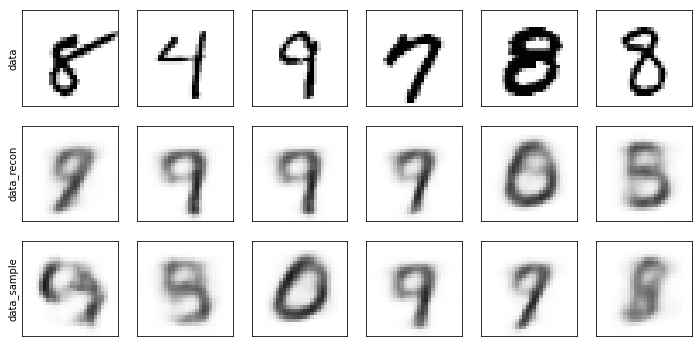

Epoch 2, Train-Loss: [3.8055,37.2190], Test-Loss: [4.1099,36.2835]
Epoch 3, Train-Loss: [4.0864,35.9657], Test-Loss: [4.1272,35.5540]
Epoch 4, Train-Loss: [4.2181,35.2826], Test-Loss: [4.2789,34.9475]
Epoch 5, Train-Loss: [4.3190,34.8176], Test-Loss: [4.3901,34.5064]
Epoch 6, Train-Loss: [4.3855,34.4868], Test-Loss: [4.3555,34.6154]


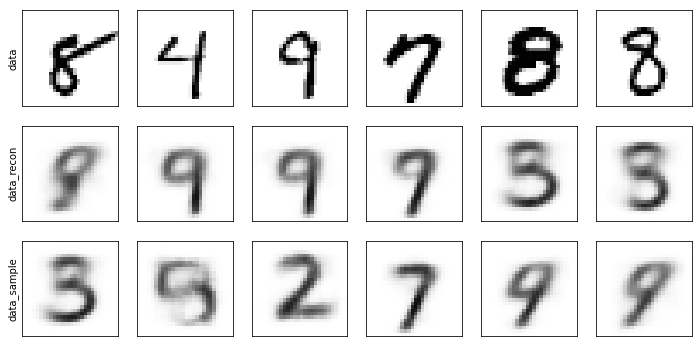

Epoch 7, Train-Loss: [4.4464,34.2639], Test-Loss: [4.4890,34.3667]
Epoch 8, Train-Loss: [4.4659,34.0718], Test-Loss: [4.4868,33.9920]
Epoch 9, Train-Loss: [4.5292,33.9022], Test-Loss: [4.5046,33.8355]
Epoch 10, Train-Loss: [4.5431,33.7336], Test-Loss: [4.5603,33.8301]
Epoch 11, Train-Loss: [4.5773,33.6697], Test-Loss: [4.7235,33.4949]


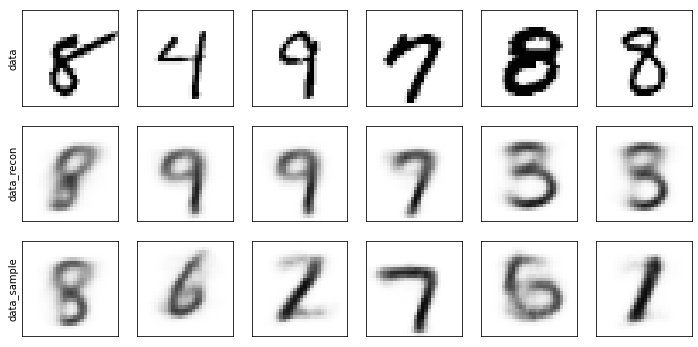

Epoch 12, Train-Loss: [4.6024,33.5156], Test-Loss: [4.6850,33.5986]
Epoch 13, Train-Loss: [4.6187,33.4431], Test-Loss: [4.5972,33.4682]
Epoch 14, Train-Loss: [4.6378,33.3210], Test-Loss: [4.6753,33.3679]
Epoch 15, Train-Loss: [4.6627,33.2555], Test-Loss: [4.7069,33.3742]
Epoch 16, Train-Loss: [4.6786,33.1841], Test-Loss: [4.6748,33.2468]


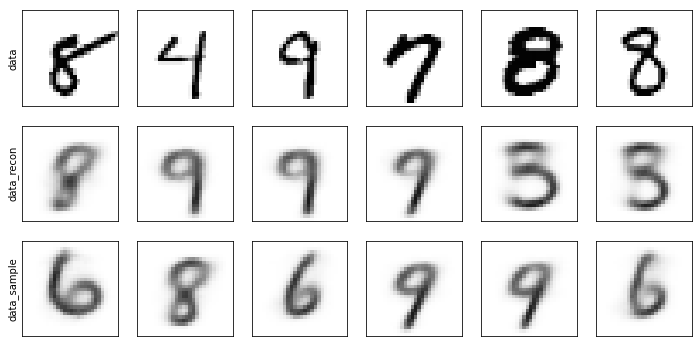

Epoch 17, Train-Loss: [4.6930,33.1149], Test-Loss: [4.6665,33.0906]
Epoch 18, Train-Loss: [4.6923,33.0639], Test-Loss: [4.7943,33.2944]
Epoch 19, Train-Loss: [4.7086,32.9992], Test-Loss: [4.4884,33.6217]
Epoch 20, Train-Loss: [4.7066,32.9674], Test-Loss: [4.7886,33.0908]
Epoch 21, Train-Loss: [4.7344,32.9096], Test-Loss: [4.8290,33.0219]


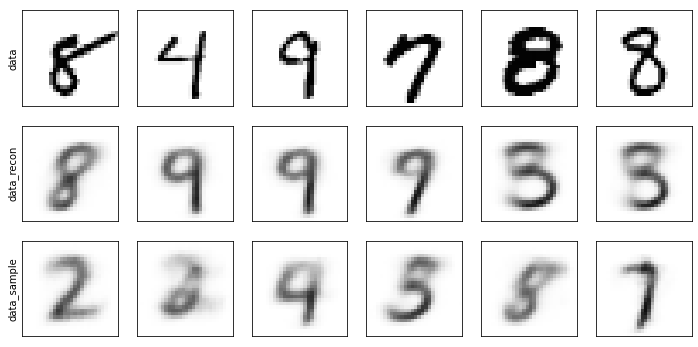

Epoch 22, Train-Loss: [4.7330,32.8643], Test-Loss: [4.6789,33.1426]
Epoch 23, Train-Loss: [4.7402,32.8151], Test-Loss: [4.6884,33.1155]
Epoch 24, Train-Loss: [4.7749,32.7605], Test-Loss: [4.6720,33.2673]
Epoch 25, Train-Loss: [4.7751,32.7258], Test-Loss: [4.6670,33.2466]
Epoch 26, Train-Loss: [4.7764,32.6888], Test-Loss: [4.7227,33.1523]


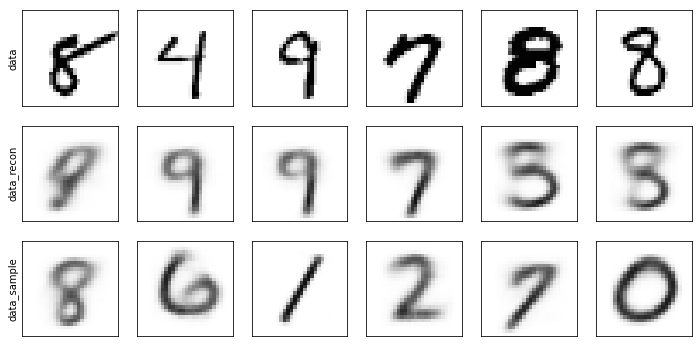

Epoch 27, Train-Loss: [4.8005,32.6527], Test-Loss: [4.7354,33.0458]
Epoch 28, Train-Loss: [4.7988,32.5997], Test-Loss: [4.7918,32.9553]
Epoch 29, Train-Loss: [4.8043,32.5767], Test-Loss: [4.7092,33.0353]
Epoch 30, Train-Loss: [4.8210,32.5395], Test-Loss: [4.8357,33.2384]
Epoch 31, Train-Loss: [4.8234,32.5207], Test-Loss: [5.0565,32.6668]


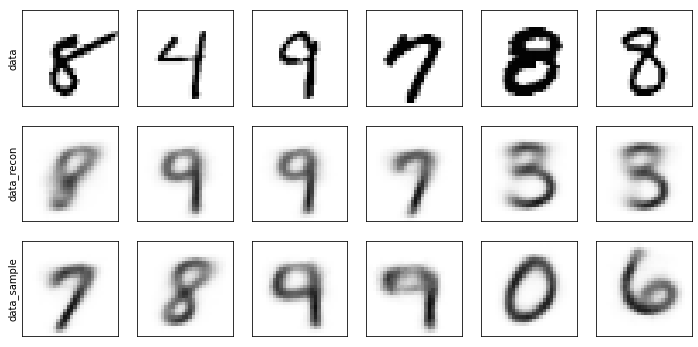

Epoch 32, Train-Loss: [4.8398,32.5077], Test-Loss: [4.7751,32.9946]
Epoch 33, Train-Loss: [4.8419,32.4668], Test-Loss: [4.7401,33.1027]
Epoch 34, Train-Loss: [4.8436,32.4527], Test-Loss: [4.7272,32.9722]
Epoch 35, Train-Loss: [4.8578,32.4050], Test-Loss: [4.8841,32.9779]
Epoch 36, Train-Loss: [4.8658,32.3785], Test-Loss: [4.9788,32.7910]


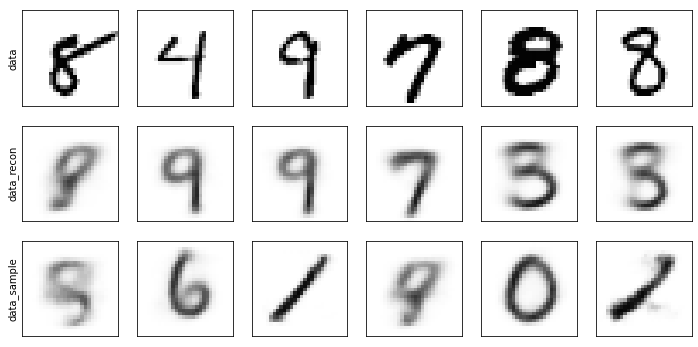

Epoch 37, Train-Loss: [4.8642,32.3689], Test-Loss: [4.8249,32.9113]
Epoch 38, Train-Loss: [4.8618,32.3352], Test-Loss: [4.7646,33.1330]
Epoch 39, Train-Loss: [4.8630,32.3196], Test-Loss: [4.7546,32.9896]
Epoch 40, Train-Loss: [4.8715,32.3263], Test-Loss: [4.7253,33.1419]
Epoch 41, Train-Loss: [4.8771,32.2677], Test-Loss: [4.7803,32.9207]


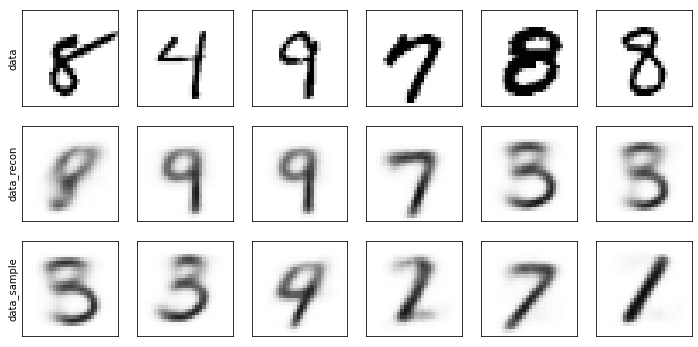

Epoch 42, Train-Loss: [4.8832,32.2864], Test-Loss: [4.8830,32.8282]
Epoch 43, Train-Loss: [4.8927,32.2352], Test-Loss: [4.9032,32.7951]
Epoch 44, Train-Loss: [4.8873,32.2024], Test-Loss: [4.8619,32.8735]
Epoch 45, Train-Loss: [4.8875,32.1904], Test-Loss: [5.0069,32.7358]
Epoch 46, Train-Loss: [4.9057,32.2034], Test-Loss: [4.9629,32.7987]


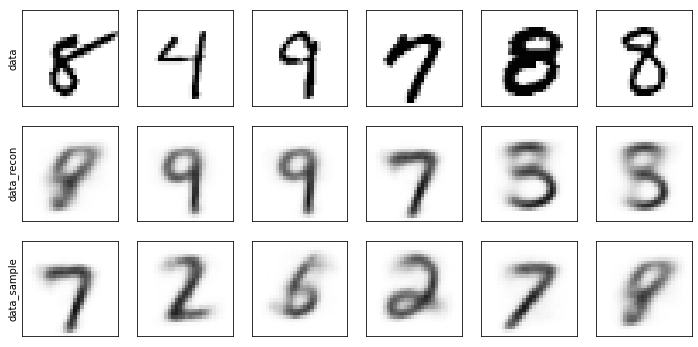

Epoch 47, Train-Loss: [4.9146,32.1440], Test-Loss: [4.9609,32.7377]
Epoch 48, Train-Loss: [4.9030,32.1524], Test-Loss: [5.1433,32.7142]
Epoch 49, Train-Loss: [4.9179,32.1471], Test-Loss: [4.9871,32.8853]
Epoch 50, Train-Loss: [4.9291,32.1165], Test-Loss: [4.8429,32.8292]


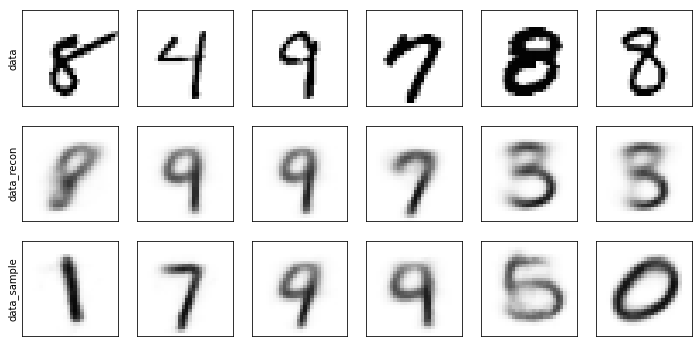

In [ ]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch in train_data:
    loss_latent, loss_recon = vae.train(x_batch)
    train_loss_latent(loss_latent)
    train_loss_recon(loss_recon)

  for x_batch_t in test_data:
    loss_latent_t, loss_recon_t = vae.compute_loss(x_batch_t)
    test_loss_latent(loss_latent_t)
    test_loss_recon(loss_recon_t)

  template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(template.format(epoch+1, train_loss_latent.result(),
                        train_loss_recon.result(), test_loss_latent.result(),
                        test_loss_recon.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_train(vae, test_data_plot, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_loss_latent.reset_states()
  train_loss_recon.reset_states()
  test_loss_latent.reset_states()
  test_loss_recon.reset_states()

### Plot grid in 2D latent space

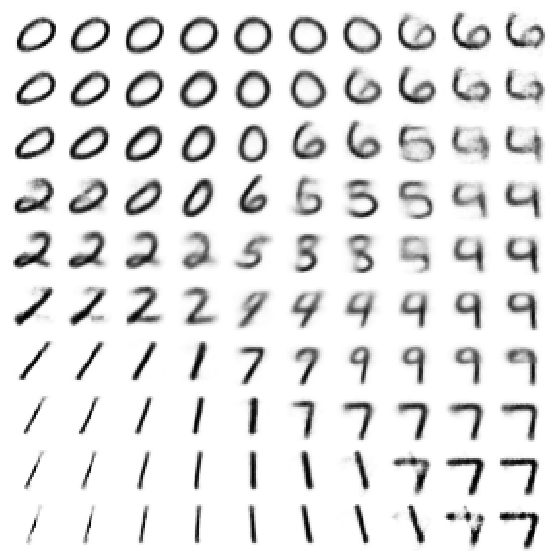

In [ ]:
# Sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = vae.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# Fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

# Save fig
figname2save = '{:s}/vae_new_z{:d}_grid.png'.format(dir_image,dim_z)
fig.savefig(figname2save)